In [21]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Dados hipotéticos (substitua pelos seus dados reais em um arquivo CSV)
data = pd.read_csv('data_/AAPL.csv')
df = pd.DataFrame(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.503662,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.080078,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.735031,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.991425,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.104767,105158200


In [6]:

# Função para calcular as médias móveis
def calculate_moving_averages(data, short_window, long_window):
    data['Short_MA'] = data['Adj Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window).mean()

# Função para identificar os cruzamentos
def identify_crossings(data):
    crossings = []
    for i in range(1, len(data)):
        if data['Short_MA'][i] > data['Long_MA'][i] and data['Short_MA'][i - 1] <= data['Long_MA'][i - 1]:
            crossings.append((data['Date'][i], 'Golden Cross'))
        elif data['Short_MA'][i] < data['Long_MA'][i] and data['Short_MA'][i - 1] >= data['Long_MA'][i - 1]:
            crossings.append((data['Date'][i], 'Death Cross'))
    return crossings

# Função para plotar os resultados
def plot_strategy(data, crossings):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['Adj Close'], label='Preço')
    plt.plot(data['Date'], data['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
    plt.plot(data['Date'], data['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
    for date, cross_type in crossings:
        plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.title('Estratégia de Cruzamento de Médias Móveis')
    plt.show()

Cruzamentos:
2021-04-13: Golden Cross
2021-05-17: Death Cross
2021-06-21: Golden Cross
2021-09-22: Death Cross
2021-10-27: Golden Cross
2022-01-25: Death Cross
2022-02-09: Golden Cross
2022-02-16: Death Cross
2022-03-28: Golden Cross
2022-04-22: Death Cross
2022-07-15: Golden Cross
2022-09-09: Death Cross
2022-11-21: Golden Cross
2022-12-09: Death Cross


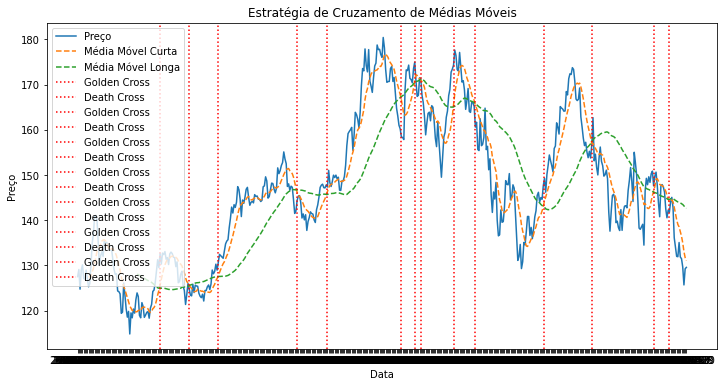

In [7]:
# Parâmetros para a análise
short_window = 10
long_window = 50

# Realiza a análise
calculate_moving_averages(df, short_window, long_window)
crossings = identify_crossings(df)

# Exibe o resultado
print("Cruzamentos:")
for date, cross_type in crossings:
    # Verifica se 'date' é uma string e converte para objeto de data, se necessário
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d')  # Converte a string para objeto de data
    print(f"{date.strftime('%Y-%m-%d')}: {cross_type}")

# Plota o gráfico
plot_strategy(df, crossings)

In [11]:
# Função para calcular o retorno acumulado da estratégia
def calculate_cumulative_returns(data, short_window, long_window):
    data['Position'] = 0
    data.loc[data['Short_MA'] > data['Long_MA'], 'Position'] = 1
    data['Returns'] = data['Adj Close'].pct_change() * data['Position'].shift()
    cumulative_returns = (data['Returns'] + 1).cumprod()
    if len(cumulative_returns) > 0:
        return cumulative_returns.iloc[-1]  # Retorna o último valor do DataFrame
    else:
        return 1  # Retorna 1 se não houver dados para calcular o retorno acumulado

In [ ]:
# Função para calcular a taxa de acerto da estratégia
def calculate_accuracy(data, short_window, long_window):
    data['Signal'] = 0
    data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1
    data['Actual_Signal'] = data['Signal'].shift()
    correct_signals = data[data['Signal'] == data['Actual_Signal']]
    accuracy = len(correct_signals) / len(data)
    return accuracy

In [ ]:
# Parâmetros para otimização
short_window_range = range(5, 21, 5)
long_window_range = range(20, 101, 10)

# Otimiza a estratégia
best_cumulative_returns = 0
best_short_window = 0
best_long_window = 0

for short_window in short_window_range:
    for long_window in long_window_range:
        if short_window >= long_window:
            continue

        calculate_moving_averages(df, short_window, long_window)
        cumulative_returns = calculate_cumulative_returns(df, short_window, long_window)

        if cumulative_returns > best_cumulative_returns:
            best_cumulative_returns = cumulative_returns
            best_short_window = short_window
            best_long_window = long_window


# Exibe os resultados da otimização
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")

# Re-calcular as médias móveis com as melhores janelas
calculate_moving_averages(df, best_short_window, best_long_window)
crossings = identify_crossings(df)

# Plota o gráfico atualizado com a melhor estratégia
plot_strategy(df, crossings)

Melhor combinação de janelas móveis: Short Window = 15, Long Window = 20
Retorno acumulado: 1.25
Drawdown máximo: -35.38%


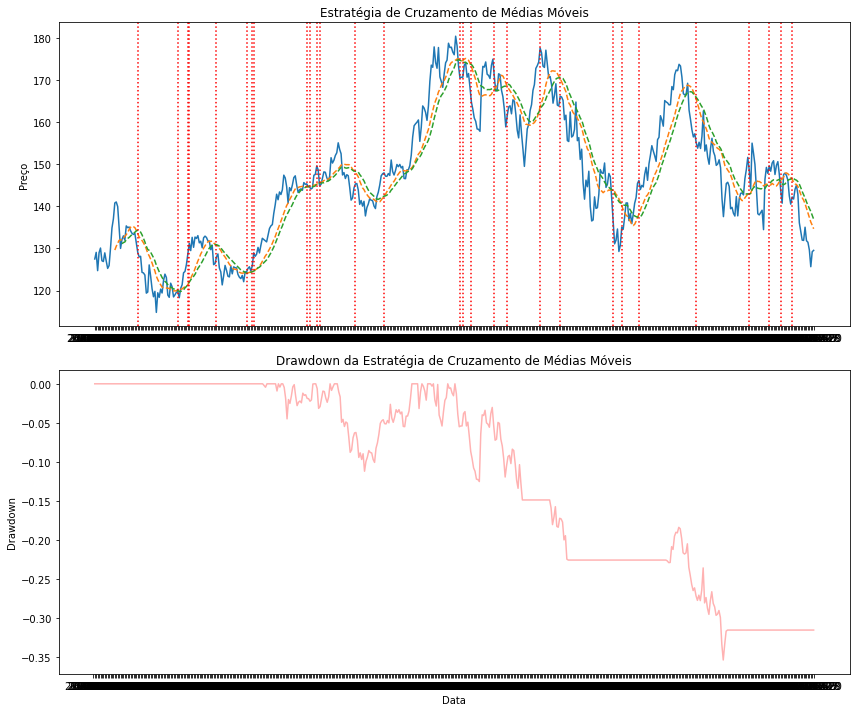

In [16]:
# Função para calcular o drawdown máximo da estratégia
def calculate_max_drawdown(data):
    data['Cumulative_Returns'] = (data['Returns'] + 1).cumprod()
    data['Peak'] = data['Cumulative_Returns'].cummax()
    data['Drawdown'] = data['Cumulative_Returns'] / data['Peak'] - 1
    max_drawdown = data['Drawdown'].min()
    return max_drawdown

# Calcula o drawdown máximo da melhor estratégia
calculate_moving_averages(df, best_short_window, best_long_window)
df['Returns'] = df['Adj Close'].pct_change() * df['Position'].shift()
max_drawdown = calculate_max_drawdown(df)

# Exibe o resultado da otimização com o drawdown máximo
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")
print(f"Drawdown máximo: {max_drawdown:.2%}")

# Plota o gráfico atualizado com a melhor estratégia
plt.figure(figsize=(12, 10))

# Subplot para a estratégia da média móvel
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
#plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
#plt.legend()
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()

In [22]:
# Calcula os retornos positivos
df['Positive_Returns'] = df['Returns'].copy()
df['Positive_Returns'][df['Positive_Returns'] < 0] = 0

# Calcula o drawdown máximo da melhor estratégia
calculate_moving_averages(df, best_short_window, best_long_window)
df['Returns'] = df['Adj Close'].pct_change() * df['Position'].shift()
max_drawdown = calculate_max_drawdown(df)

Melhor combinação de janelas móveis: Short Window = 15, Long Window = 20
Retorno acumulado: 1.25
Drawdown máximo: -35.38%
Índice de Sharpe: -0.15


C:\Users\Caíque Miranda\AppData\Local\Temp\ipykernel_11132\426401348.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos


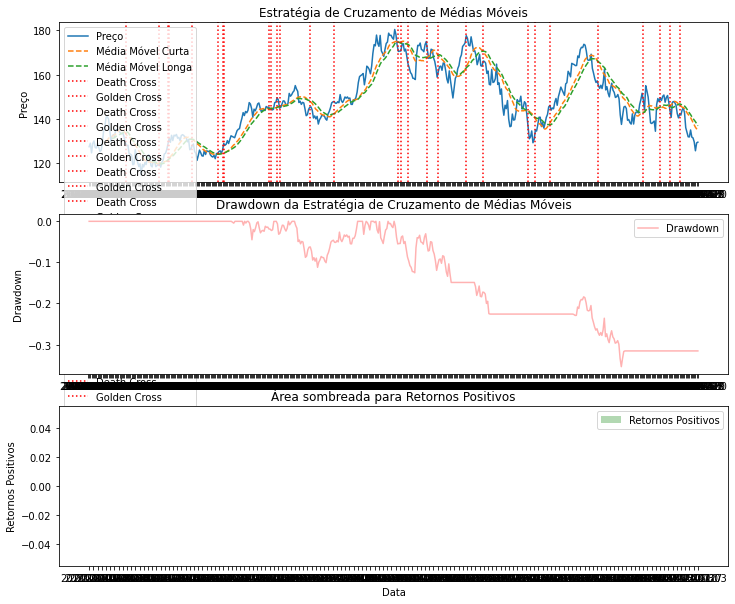

In [20]:
# Função para calcular o Índice de Sharpe
def calculate_sharpe_ratio(data):
    excess_returns = data['Returns'] - 0.01 / 252  # Assumindo taxa de juros livre de risco de 1% ao ano
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    return sharpe_ratio

# Calcula o Índice de Sharpe da melhor estratégia
sharpe_ratio = calculate_sharpe_ratio(df)

# Exibe o resultado da otimização com o drawdown máximo e o Índice de Sharpe
print(f"Melhor combinação de janelas móveis: Short Window = {best_short_window}, Long Window = {best_long_window}")
print(f"Retorno acumulado: {best_cumulative_returns:.2f}")
print(f"Drawdown máximo: {max_drawdown:.2%}")
print(f"Índice de Sharpe: {sharpe_ratio:.2f}")

# Plota o gráfico atualizado com a melhor estratégia e os indicadores
plt.figure(figsize=(12, 10))

# Subplot para a estratégia da média móvel
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Adj Close'], label='Preço')
plt.plot(df['Date'], df['Short_MA'], label='Média Móvel Curta', linestyle='dashed')
plt.plot(df['Date'], df['Long_MA'], label='Média Móvel Longa', linestyle='dashed')
for date, cross_type in crossings:
    plt.axvline(date, color='red', linestyle='dotted', label=cross_type)
plt.legend()
plt.ylabel('Preço')
plt.title('Estratégia de Cruzamento de Médias Móveis')

# Subplot para o drawdown
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['Drawdown'], color='red', alpha=0.3, label='Drawdown')
plt.legend()
plt.ylabel('Drawdown')
plt.title('Drawdown da Estratégia de Cruzamento de Médias Móveis')

# Subplot para a área sombreada de retornos positivos
plt.subplot(3, 1, 3)
positive_returns = df[df['Drawdown'] >= 0]
plt.fill_between(positive_returns['Date'], positive_returns['Drawdown'], 0, facecolor='green', alpha=0.3, label='Retornos Positivos')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Retornos Positivos')
plt.title('Área sombreada para Retornos Positivos')

plt.tight_layout()  # Para evitar sobreposição de rótulos e títulos
plt.show()